# Time Series Forecasting Using ARIMA\SARIMA Models

In [12]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

## Prepare Data for Modeling

##### Filtering out the  Raw Tesla data

In [3]:
# Filter Tesla scaled data only
raw_tesla_df = df[df["Ticker"] == "TSLA"].copy()

# Sort chronologically
tesla_df = raw_tesla_df.sort_values("Date").reset_index(drop=True)

print(f"Tesla dataset loaded with {tesla_df.shape[0]} rows")
print(f"Date range from {tesla_df['Date'].min()} to {tesla_df['Date'].max()}")


Tesla dataset loaded with 2775 rows
Date range from 2015-01-02 00:00:00 to 2026-01-14 00:00:00


In [5]:
series = tesla_df.set_index('Date')['Close']
series_returns = series.pct_change().dropna()

# Split chronologically
split_date = pd.Timestamp('2025-01-01')
train = series[series.index < split_date]
test = series[series.index >= split_date]

train_returns = series_returns[series_returns.index < split_date]
test_returns = series_returns[series_returns.index >= split_date]


print(f"Training samples: {len(train)} prices, {len(train_returns)} returns")
print(f"Testing samples: {len(test)} prices, {len(test_returns)} returns")
print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

Training samples: 2516 prices, 2515 returns
Testing samples: 259 prices, 259 returns

Training period: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Testing period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00


In [7]:
# =============================================================
# BUILD ARIMA MODEL ON RETURNS
# =============================================================
# ARIMA(p, d, q) parameters:
# p = autoregressive order
# d = differencing order (0 since returns are already stationary)
# q = moving average order

# Fit ARIMA model on training returns
model = ARIMA(train_returns, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2515
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4792.757
Date:                Sat, 24 Jan 2026   AIC                          -9577.514
Time:                        12:21:54   BIC                          -9554.194
Sample:                             0   HQIC                         -9569.050
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.441      0.015       0.000       0.004
ar.L1          0.8639      0.143      6.027      0.000       0.583       1.145
ma.L1         -0.8494      0.150     -5.678      0.0

In [8]:
# =============================================================
# FORECAST RETURNS
# =============================================================
# Forecast returns for the test period
n_forecast = len(test_returns)
forecast_returns = model_fit.forecast(steps=n_forecast)

print(f"Forecasted {n_forecast} return values")
print(f"\nForecast statistics:")
print(f"  Mean forecasted return: {forecast_returns.mean():.6f}")
print(f"  Actual mean return: {test_returns.mean():.6f}")

Forecasted 259 return values

Forecast statistics:
  Mean forecasted return: 0.001928
  Actual mean return: 0.001096


In [9]:
# =============================================================
# CONVERT RETURNS FORECAST TO PRICES
# =============================================================
# Start from the last training price
last_train = train.iloc[-1]

# Convert returns to prices using cumulative product
forecast_prices = last_train * (1 + forecast_returns).cumprod()

# Align index with test data
forecast_prices.index = test.index

print(f"Last training price: ${last_train:.2f}")
print(f"First forecasted price: ${forecast_prices.iloc[0]:.2f}")
print(f"Last forecasted price: ${forecast_prices.iloc[-1]:.2f}")

Last training price: $403.84
First forecasted price: $404.25
Last forecasted price: $665.07


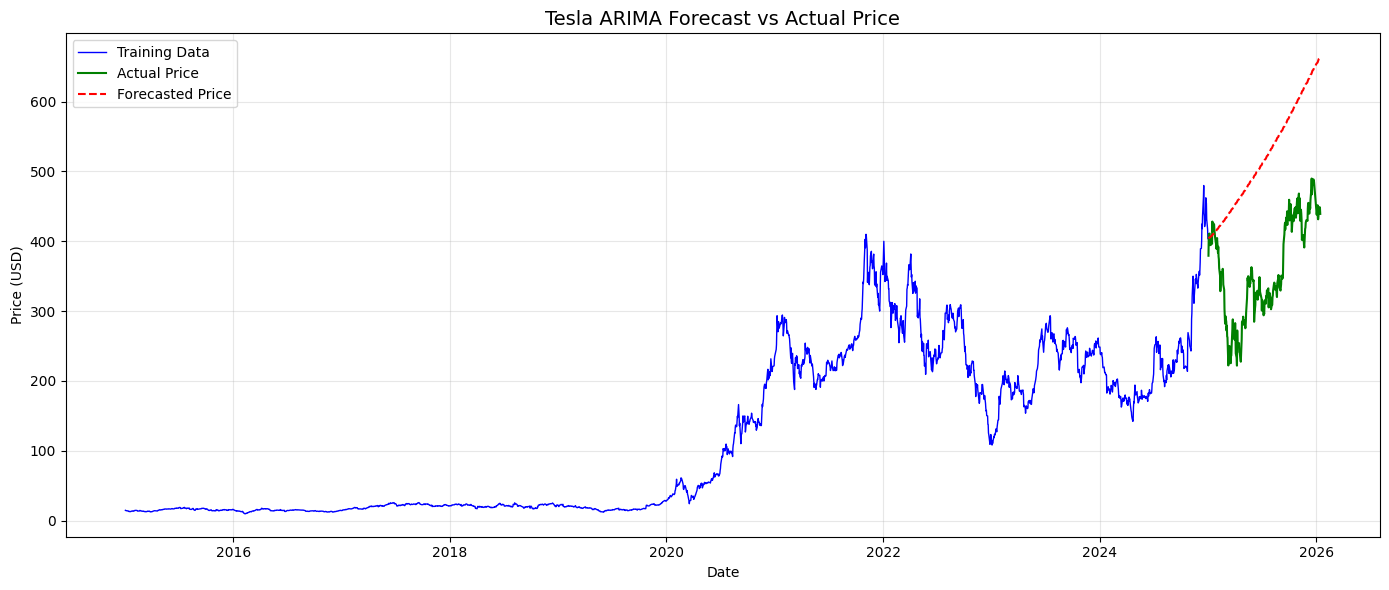

In [11]:
# =============================================================
# VISUALIZE FORECAST RESULTS
# =============================================================
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train, label="Training Data", color='blue', linewidth=1)

# Plot actual test data
plt.plot(test, label="Actual Price", color='green', linewidth=1.5)

# Plot forecast
plt.plot(forecast_prices, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla ARIMA Forecast vs Actual Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# =============================================================
# EVALUATE FORECAST ACCURACY
# =============================================================
# Calculate error metrics
mae = mean_absolute_error(test, forecast_prices)
rmse = np.sqrt(mean_squared_error(test, forecast_prices))
mape = np.mean(np.abs((test - forecast_prices) / test)) * 100

print("Forecast Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE): ${mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Forecast Evaluation Metrics:
  Mean Absolute Error (MAE): $163.18
  Root Mean Squared Error (RMSE): $173.35
  Mean Absolute Percentage Error (MAPE): 48.51%
